# Dataset Preprocessing
This notebook is used for the data preprocessing of [CelebA dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

## CelebA Dataset
CelebA dataset consists of triplets of images (anchor, positive, negative) used for face recognition in addition to analytic features describing each image such as: gender, hair color, glasses, age, ...   

## Preprocessing function
* images are resized, normalized and saved as numpy arrays.   
* Anchor images are matched to their triplets (positive and negative)
* Each image is matched to its features that will be used in training which are age and gender.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Depi/Project/Model_training/celebA Dataset'

# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

# Define Paths
images_path = os.path.join(base_path, 'CelebA FR Triplets/CelebA FR Triplets/images/')  # Path to images
labels_path = os.path.join(base_path, 'CelebAAttrs.csv')  # Path to attributes CSV
triplets_path = os.path.join(base_path, 'CelebA FR Triplets/CelebA FR Triplets/triplets.csv')

# Load the Dataset attributes
attributes = pd.read_csv(labels_path)

# Load triplets mapping (anchor, positive, negative)
triplets = pd.read_csv(triplets_path)

X_anchor = triplets['anchor']
Y_anchor = triplets['id1']
X_pos = triplets['pos']
Y_pos = triplets['id2']
X_neg = triplets['neg']
Y_neg = triplets['id3']

# Select Relevant Attributes (For Gender and Age Classification)
attributes['Male'] = attributes['Male'].apply(lambda x: 1 if x == 1 else 0)
attributes['Young'] = attributes['Young'].apply(lambda x: 1 if x == 1 else 0)

# Filter relevant columns and limit to 25,000 images
selected_attributes = attributes[['image_id', 'Male', 'Young']]  # Limit to first 25,000 images


In [ ]:
# Function to preprocess images: resize and normalize
def preprocess_image(image_path, id):
    try:
        # Open the image using PIL
        image = Image.open(image_path).convert('RGB')
        # Resize image to 64x64
        image = image.resize((75, 75))
        # Normalize pixel values (0-255 to 0-1)
        image = np.array(image) / 255.0
        return image, id
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [ ]:
# Apply preprocessing to anchor, posiive and negative images
for type_id in ['anchor', 'pos', 'neg']:

    # Preprocess images using multithreading
    image_data = []
    labels_gender = []
    labels_age = []
    labels_id = []

    # Use ThreadPoolExecutor for concurrent image loading
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust the number of workers as needed
        futures = []

        # Anchor images processing
        for i, row in triplets.iterrows():
            image_path = os.path.join(images_path, row[type_id])
            futures.append(executor.submit(preprocess_image, image_path, row[type_id]))

        for i, future in enumerate(futures):
            result, id = future.result()
            if result is not None:
                image_data.append(result)
                attributes = selected_attributes.loc[selected_attributes['image_id'] == id]
                labels_id.append(id)                             # Save image id
                labels_gender.append(attributes['Male'].item())  # Get corresponding gender label
                labels_age.append(attributes['Young'].item())      # Get corresponding age label

    # Convert lists to numpy arrays
    image_data = np.array(image_data)
    labels_gender = np.array(labels_gender)
    labels_age = np.array(labels_age)
    labels_id = np.array(labels_id)

    # Save Preprocessed Data to Google Drive
    image_path = os.path.join(base_path, f'Matching_triplets/{type_id}_image.npy')
    gender_path = os.path.join(base_path, f'Matching_triplets/{type_id}_gender.npy')
    age_path = os.path.join(base_path, f'Matching_triplets/{type_id}_age.npy')
    id_path = os.path.join(base_path, f'Matching_triplets/{type_id}_id.npy')

    np.save(image_path, image_data)
    np.save(gender_path, labels_gender)
    np.save(age_path, labels_age)
    np.save(id_path, labels_id)

    # Output the shape of the datasets
    print(f"{type_id}_dataset: {image_data.shape}, {labels_gender.shape}, {labels_age.shape}")

anchor_dataset: (16332, 75, 75, 3), (16332,), (16332,)
pos_dataset: (16332, 75, 75, 3), (16332,), (16332,)
neg_dataset: (16332, 75, 75, 3), (16332,), (16332,)


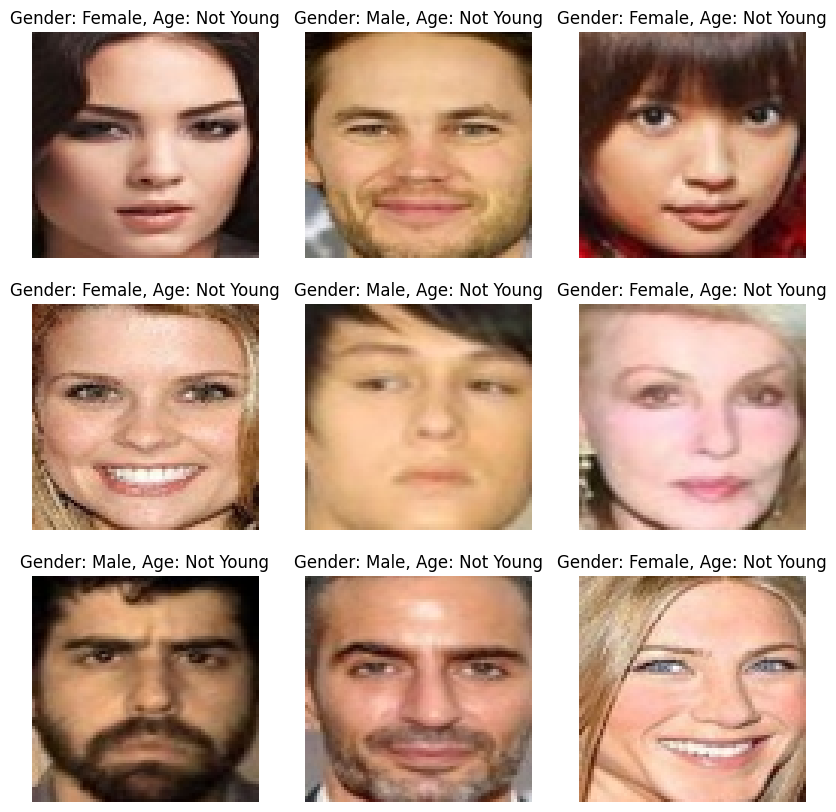

In [ ]:

# Optionally visualize some preprocessed images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_data[i])
    plt.title(f"Gender: {'Male' if labels_gender[i] == 1 else 'Female'}, Age: {'Young' if labels_age[i] == 1 else 'Not Young'}")
    plt.axis('off')
plt.show()
